# 패키지 정의하기

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### 모델이 각 epoch 마다 처리되는 상황을 보여줌
# 설치하기 : conda install -c conda-forge tqdm
from tqdm import tqdm

from keras.layers import Input
### Model : 멀티 모델 생성 클래스
### Sequential : 일반 모델 생성 클래스
from keras.models import Model, Sequential
### Dense : 훈련에 참여하는 은닉층, 출력층 생성 클래스
### Dropout : 훈련에 참여하지는 않는 전처리 계층
from keras.layers.core import Dense, Dropout
### advanced_activations : 활성화 객체 정의
# - LeakyReLU : 일반적인 relu와 동일 (sigmoid 개선 객체)
#   >> 0보다 작으면 0으로, 0보다 크면 1로  반환해 주는 객체
from keras.layers.advanced_activations import LeakyReLU
### 케라스에서 제공해 주는 데이터셋 사용
# - mnist : 0~9까지의 단일 숫자 이미지 데이터
from keras.datasets import mnist
### 모델 설정 시 사용할 손실율 계산 클래스
# - GAN에서 성능이 좋은 Adam 사용
from tensorflow.keras.optimizers import Adam
### 케라스 초기화 및 초기설정 클래스
from keras import initializers

# 전체 기본 설정

In [2]:
### keras가 tensorflow를 벡엔드로 사용할 수 있도록 지정
# - 텐서 버전이 2.0보다 작은경우에는 아래 정의해야하며,
# - 2.0 이상인 버전에서는 안해도 되지만, 
#   간혹 오류나는 경우가 있어서 해두면 좋음
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
### 훈련을 재현할 때 동일한 결과를 얻을 수 있도록 하기위해
#  - seed 내에 숫자는 의미는 없음..
#  - 넘파이가 숫자값으로 랜덤한 값들의 패턴을 만들어서 제공해 줌
np.random.seed(10)

In [4]:
### 가짜 이미지 생성에 사용할 노이즈 값
# - 랜덤한 노이즈 데이터(벡터)의 차원값을 설정함
# - 밑에서 가짜 이미지 생성시에 사용되는 변수 설정
random_dim = 100

# MNIST 데이터 읽어 들이기

In [5]:
### 데이터 수집하기
# 사용 변수 
# - 훈련 데이터 : x_train, y_train
# - 테스트 데이터 : x_test, y_test
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [6]:
### 정규화 하기
# - 데이터를 픽셀 최대값인 255의 절반값을 사용
# - -1 ~ 1 사이의 값으로 만듭니다. (255/2)
# - 생성기의 출력층에 사용하는 활성화 함수에 탄젠트 사용하여
#   -1 ~ 1의 값으로 출력되게 함
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train.shape

(60000, 28, 28)

In [7]:
### 사용되는 픽세의 너비, 높이 2차원 데이터를 
# - 1차원으로 만들기 = 너비 x 높이
x_train = x_train.reshape(60000, 28 * 28)
x_train.shape

(60000, 784)

# 모델 생성 및 계층 생성(Generator)

In [8]:
### Generator(생성기) 모델 생성하기
generator = Sequential()

### 계층 추가하기
# - stddev : 랜덤한 난수값 생성(표준편차 값)
# - 계층 초기값 설정 : kernel_initializer
# - input_dim : 입력차원 (100)
# - 256 : 뉴런(출력) 갯수
generator.add(Dense(256, input_dim=random_dim,
                    kernel_initializer=\
                        initializers.RandomNormal(stddev=0.02)))
### relu 계층 추가
generator.add(LeakyReLU(0.2))

### upsample : 뉴런의 갯수 증가 시키기
# - 진짜같은 이미지를 만들기 위해 가중치 증가시킴
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

### 최종 출력층 생성하기
# - tanh : 탄젠트 알고리즘(-1 ~ 1의 범위 값으로 출력)
# - 최종 뉴런은 원본의 픽셀 갯수로 원상복귀...(가짜 이미지 1개)
generator.add(Dense(784, activation = "tanh"))

### 모델 생성 및 계층 추가하기 (Discriminator:판별기)

In [9]:
### 모델 생성하기
discriminator = Sequential()

### 사용되는 뉴런의 갯수는 생성할 때의 반대로 진행됨
discriminator.add(Dense(1024, input_dim=784, 
    kernel_initializer=initializers.RandomNormal(stddev=0.02)))

###  relu 계층 추가하기
# - 0인값을 다음 계층으로 넘기는 경우,
#   모든 뉴런들의 출력값이 0으로 되는 현상을 막기 위해서
# - relu를 개선한 LeakyReLU 계층이 만들어 졌음
# - 0이 아닌 음수의 값을 생성하여 넘길 수 있는 방법을 이용하여
# - 음수의 값 일부만을 넘길 수 있도록 처리하기 위한 방법
# - 0.2 = 20%의 음수값을 다음 계층으로 넘기기 위한 방법
discriminator.add(LeakyReLU(0.2))
### 전처리 계층 사용 : 일부 데이터 사용 못하게 처리
discriminator.add(Dropout(0.3))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

## 최종 출력층 추가하기
discriminator.add(Dense(1, activation="sigmoid"))

# 모델 설정 : 컴파일 하기(옵티마이저 정의)

In [10]:
### 모델 설정 : 옵티마이저 adam 정의
# - learning_rate = 학습률(보폭)
# - beta_1 : 방향과 보폭을 모두 적당하게 유지시키는 속성
#          : 최적화 속성
optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)

In [11]:
### 두개 모델에 컴파일 해주기
generator.compile(optimizer=optimizer,
                  loss="binary_crossentropy")

discriminator.compile(optimizer=optimizer,
                  loss="binary_crossentropy")

# 두개의 모델 합치기 : 멀티 모델 만들기

In [12]:
### 두개 모델을 동시에 학습시키고 싶을 때 
# - trainable 값을 False로 설정
# - 판별기에서 생성기의 데이터와 자기 자신의 데이터를 비교
discriminator.trainable = False

### GAN 멀티모델 생성을 위한 입력 데이터 생성
# - 생성기와 판별기의 초기값과 동일한 차원 사용
gan_input = Input(shape=random_dim, )
### Generator() 함수(추후 생성해서 사용)에게 초기값을 넘긴 후
# - 최종 결과값을 얻어와야함
# - 생성기의 최종 결과값은 = 이미지
x = generator(gan_input)

### 판별기 함수()에 생성기의 결과 이미지 데이터를 넘기기
# - 판별기는 진짜/가짜만 판별함
# - 판별기의 최종 결과 값은 = 확률로 알려줌
gan_output = discriminator(x)

### GAN 모델 생성 : 멀티모델
# - 멀티 모델 생성 방법 : 입력과 출력 데이터를 넘겨주면 됨
# - 입력이 2개(input, output)인 계층을 동시에 사용하게 됨
# - 전이학습에서 사용되는 개념...
# - 기존의 데이터 가중치를 활용헤서 앞으로도 계속 upgrade 사용..
gan = Model(inputs = gan_input, outputs = gan_output)

### GAN 모델도 컴파일 해야함
gan.compile(optimizer=optimizer,
            loss="binary_crossentropy")

# 생성된 MNIST 이미지 시각화

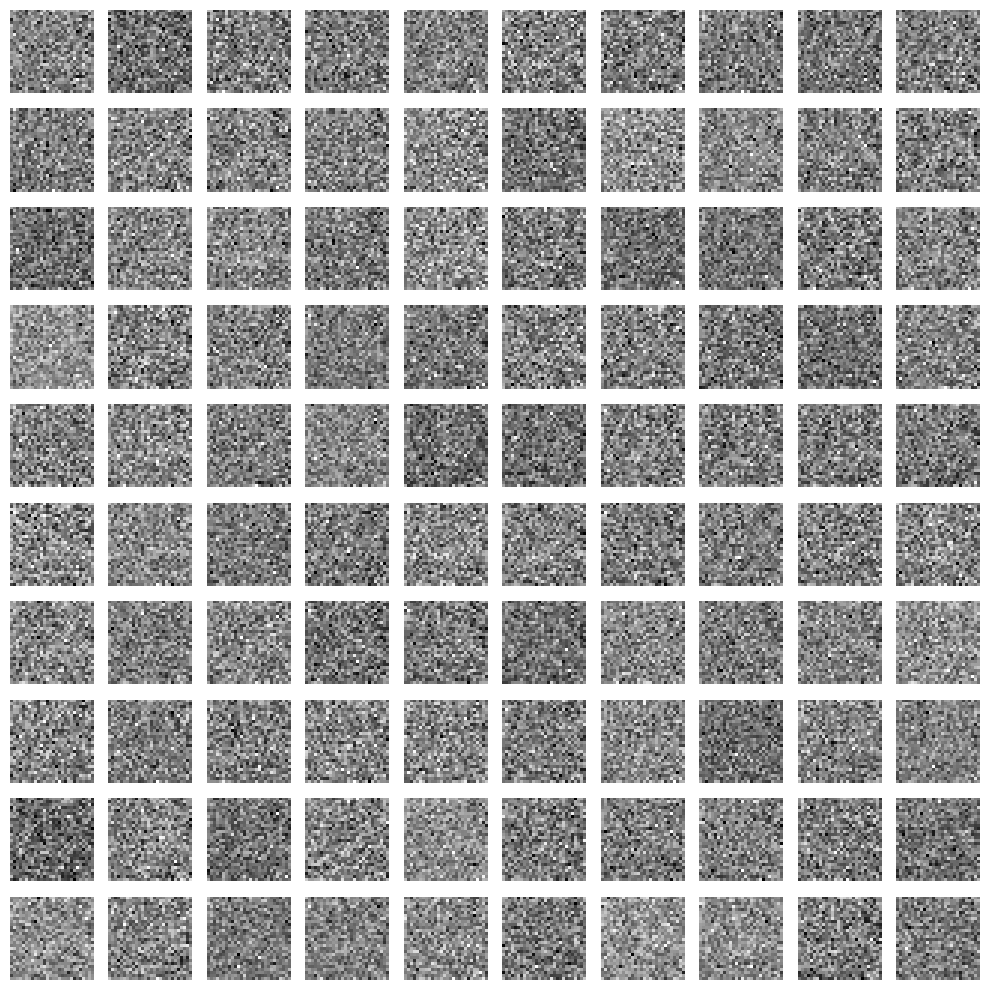

In [13]:
epoch = 0
examples = 100
dim = (10, 10)
### 너비, 높이
figsize = (10, 10)

### 랜덤한 2차원 데이터 생성
# - 0~1 사이의 값으로
# - size(100행, 100열)로 데이터 랜덤하게 생성
noise = np.random.normal(0, 1,
                         size=[examples, random_dim])
# len(noise[0])
### 생성기를 통해 랜덤한 데이터를 전달하여
#   - 이미지데이터 생성하기
#   - 결과값 : 이미지 데이터
generated_images = generator.predict(noise)
### 이미지로 보여주기 위행 : 3차원 데이터로 만들기
generated_images = generated_images.reshape(examples, 28, 28)

### 그림 그리기
plt.figure(figsize=figsize)

### for문 100번 반복 : generated_images.shape[0]
for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i],
               interpolation="nearest",
               cmap = "gray_r")
    plt.axis("off")
plt.tight_layout()
plt.savefig("./01_images/gan_generated_image_epoch_{}.png".format(epoch))

# GAN 전체 훈련 및 이미지 생성 로직 수행

--------------- Epoch 1 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:31<00:00, 14.76it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.56it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.50it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.07it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.71it/s]


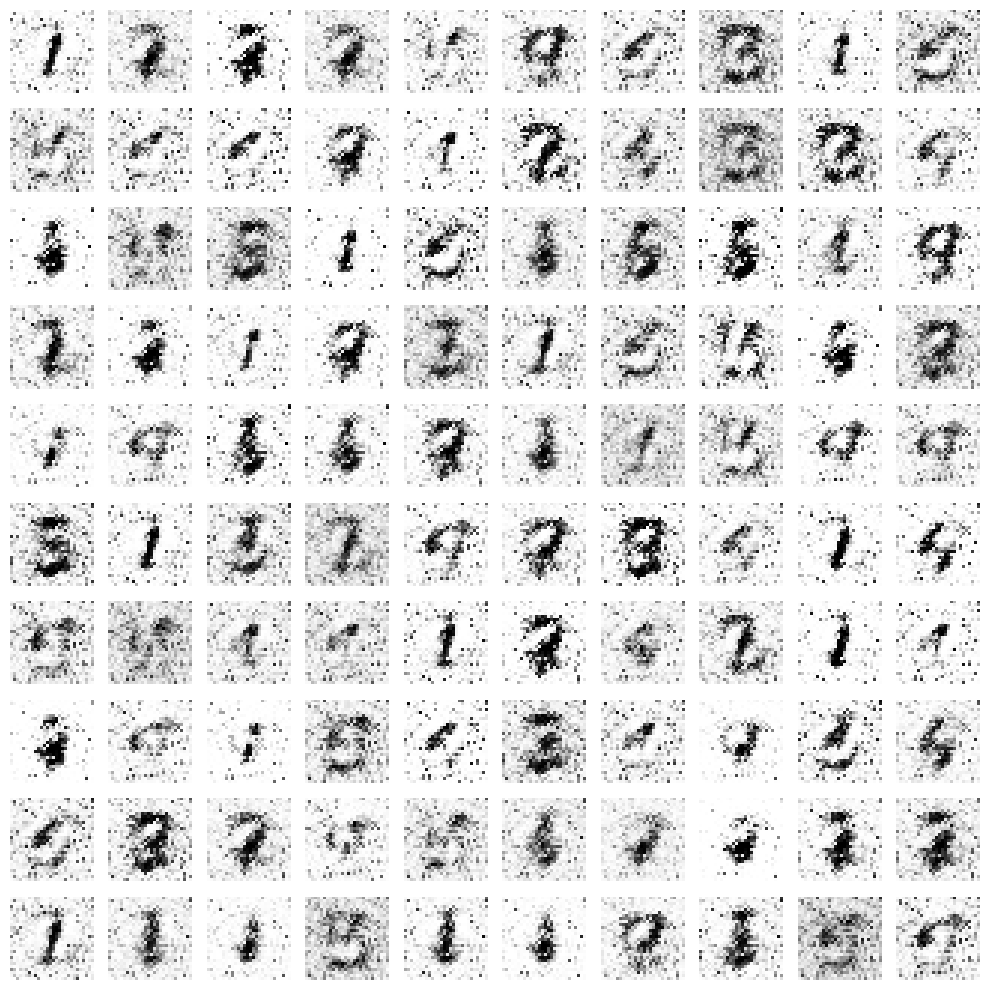

In [14]:
epochs = 5
batch_size=128
### load_mnist_data() 함수 호출 부분
# - 데이터 읽어 들이는 부분 (위에 정의만 해 놓았음)
# x_train, y_train, x_test, y_test = load_mnist_data()

### batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 설정
# - train 데이터를 128 사이즈의 batch로 나눠줌
batch_count = x_train.shape[0] // batch_size

### Generator 및 Discriminator, 멀티 Gan 모델 및 계층 생성 (정의만 해놓았음)
# - 이후 함수 호출로 사용

### 훈련 시키기
for e in range(1, epochs + 1) :
    print("-"*15, "Epoch {}".format(e), "-"*15)
    
    ### 훈련 진행 상태 확인하기 (tqdm() 사용)
    for _ in tqdm(range(batch_count)) :
        ### 입력으로 사용할 랜덤한 노이즈 생성
        noise = np.random.normal(0, 1, 
                                 size=[batch_size, random_dim])
        ### 입력으로 사용할 랜덤한 이미지 데이터 생성
        image_batch = x_train[np.random.randint(0,
                                                x_train.shape[0],
                                                size = batch_size)]
        
        ### MNIST 이미지 생성하기 : Generator 사용
        # - 예측(predict) 함수 실행하여 이미지 데이터 얻기
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])
        
        ### np.zeros() : 0으로 채워진 1차원 배열 생성
        y_dis = np.zeros(2 * batch_size)
        y_dis[ : batch_size] = 0.9
        
        ### Discriminator 학습 시키기
        # - classification layer를 학습한 뒤에..
        # - 결과값을 이용해서 다시, feature map과 classification layer를 합쳐서
        #   전체 layer를 다시 학습하고자 할때 True로 설정
        # - 최초에는 feature map이 랜덤값을 사용하게 되지만,
        #   학습 이후 부터는 이전의 weight값을 이용할 수 있도록 함(전이학습 개념)
        discriminator.trainable = True
        
        ### train_on_batch()
        # - 이미 존재하는 모델에 새로운 학습 데이터셋을 받아서
        #   이전의 모델이 학습한 가중치의 값으로 학습 시킬 수있도록 하는 장점 활용
        # - GAN은 기존 이미지의 가중치 값을 그대로 이용해서 향상시키기 때문에....
        discriminator.train_on_batch(X, y_dis)
        
        ### Generator 학습
        noise = np.random.normal(0, 1, 
                                 size=[batch_size, random_dim])
        ### ones() : 1로 배열 생성하기
        # - zeros()의 반대 개념
        y_gen = np.ones(batch_size)
        
        ### GAN 모델 훈련
        ### discriminatro의 기능을 다시 멀티 모델 수행방식으로 설정
        discriminator.trainable = False        
        gan.train_on_batch(noise, y_gen)
    
    ### 시각화는 성능을 고려해서 최초 1회, 이후부터 20회마다 한번씩 시각화/저장
    # 위에 정의한 시각화 부분을 함수 호출 방식으로 사용
    if e==1 or e%20==0 :
        epoch = e
        examples = 100
        dim = (10, 10)
        ### 너비, 높이
        figsize = (10, 10)

        ### 랜덤한 2차원 데이터 생성
        # - 0~1 사이의 값으로
        # - size(100행, 100열)로 데이터 랜덤하게 생성
        noise = np.random.normal(0, 1,
                                 size=[examples, random_dim])
        # len(noise[0])
        ### 생성기를 통해 랜덤한 데이터를 전달하여
        #   - 이미지데이터 생성하기
        #   - 결과값 : 이미지 데이터
        generated_images = generator.predict(noise)
        ### 이미지로 보여주기 위행 : 3차원 데이터로 만들기
        generated_images = generated_images.reshape(examples, 28, 28)

        ### 그림 그리기
        plt.figure(figsize=figsize)

        ### for문 100번 반복 : generated_images.shape[0]
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i],
                       interpolation="nearest",
                       cmap = "gray_r")
            plt.axis("off")
        plt.tight_layout()
        plt.savefig("./01_images/gan_generated_image_epoch_{}.png".format(epoch))